# Tabular Data Science - Part #2
### Group Members: 
* Tal Ariel Ziv
* Arnon Lutsky

#### Introduction:
In this project, we aim to explore the fascinating intersection of movies and data science by building a predictive model for box office revenue.<br>
In this part of the project we will improve the pipeline and our model's performance from the previews work, by modifying our data and applying more sophisticated insights on our data.<br>
This includes adding features, normalizing features and using different algorithms learned in class.<br>

### Error Analysis Conclusions & work plan:

Before we begin examining our previews work, let's load the wanted information. We will load the data from the `pickle` files.


In [1]:
import pickle

with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In part 1 of the project, we saw that the residuals precents were highest when `revenue` was smaller, as seen in Figure 7 in the last parts notebook.<br>
This may be because several reasons:<br>
* Log transformation: as seen in figure 1 of last part's notebooks, there is high skweness in the distribution of th `revenue` feature. Because many movies had low revenue the model could get "confused" and predict low `revenue` for many movies with higher `revenue` values.<br>

* Massive filterring left us with around 10% of the dataset. We will implement ways to use data that may have a missing value. <br>

## Log transformation

We will perform a log transformation on the `revenue` to decrease the skweness.
The plot shows that the data distribution behaves more normally and is less skwed.

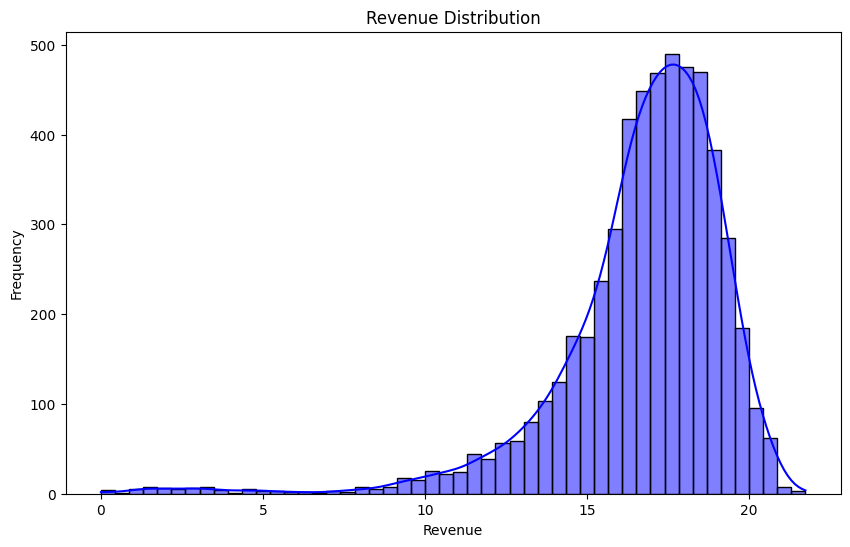

In [ ]:
data_movies['revenue'] = np.log(pd.to_numeric(data_movies['revenue'], errors='coerce'))

- log on the revenue value to make it normal.
- dataset size is too small (5k instead of 50k).
- not using all of our features / using them partly.



Weaknesses:
- distribution of the data
- we were left with small dataset 
- there are not many movies with high revenue as compared to low revenue.
- because there are many low revenue movies that have not a lot of info they are harder to predict.
- using partial data.


- transaction algorithem - making the revenue into buckets and calculating the avrage bucket each cast member falls into. (Brad Pitt has many high revenue movies for example)


improvemenets:
-cast to revenue "grade"
-prod company to revenue "grade"
-normlize data
- maybe look at the time of year a movie is released in (maybe around the holidays movies earn more)
- consider using overvie
- use data that has budget 0 but revenue != 0 . we'll look at the revenue of all the movies with budget 0 and see how they look. maybe use LLM (chatGPT)